In [1]:
!pip install -q yolov5 adversarial-robustness-toolbox opencv-python tensorboardX

In [2]:
import cv2
import copy
import requests
import numpy as np
from io import BytesIO
from PIL import Image
from pathlib import Path

import os
from tqdm.auto import tqdm
import shutil as sh
import random

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import DPatch, RobustDPatch

import torch
from torchvision.ops import nms

import yolov5
from yolov5.utils.loss import ComputeLoss

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Detector Model
class Yolo(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.hyp = {
            "box": 0.05,
            "obj": 1.0,
            "cls": 0.5,
            "anchor_t": 4.0,
            "cls_pw": 1.0,
            "obj_pw": 1.0,
            "fl_gamma": 0.0,
        }
        self.compute_loss = ComputeLoss(self.model.model.model)

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model.model.model(x)
            loss, loss_items = self.compute_loss(outputs, targets)
            loss_components_dict = {"loss_total": loss}
            return loss_components_dict
        else:
            return self.model(x)


yolo = yolov5.load("yolov5l.pt")  # yolov5s.pt, yolov5l.pt, yolov5s6.pt, yolov5l6.pt

yolo_model = Yolo(yolo)
yolo_model_copied = copy.deepcopy(yolo_model)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
elephant_list = os.listdir('/content/drive/MyDrive/elephant')
adversarial_list = os.listdir('/content/drive/MyDrive/elephant_onepixel')
elephant_list = sorted(elephant_list)
adversarial_list = sorted(adversarial_list)
elephant_list_jpg = [img for img in adversarial_list if img.endswith(".jpg")] # Only jpg not txt
elephant_list_txt = [img for img in elephant_list if img.endswith(".txt")] # The answer of yolo
elephant_list_txt = sorted(elephant_list_txt)

elephant_adversarial=[]
for i in adversarial_list:
  img_path = '/content/drive/MyDrive/elephant_onepixel/'+i 
  img = Image.open(img_path)
  img = img.resize((640, 640)) # To unify dimension of image
  # img preprocessing
  img = np.asarray(img)  # H W C
  img_reshape = img.transpose((2, 0, 1))  # C H W
  # [C, H, W] to [N, C, H, W]
  elephant_adversarial.append(img_reshape)
elephant = np.asarray(elephant_adversarial).astype(np.float32)

elephant=[]
for i in elephant_list_jpg:
  img_path2 = '/content/drive/MyDrive/elephant/'+i 
  img2 = Image.open(img_path2)
  img2 = img2.resize((640, 640)) # To unify dimension of image
  # img preprocessing
  img2 = np.asarray(img2)  # H W C
  img2_reshape = img2.transpose((2, 0, 1))  # C H W
  # [C, H, W] to [N, C, H, W]
  elephant.append(img2_reshape)
elephant = np.asarray(elephant).astype(np.float32)

image 1/1: 640x640 2 elephants
Speed: 9.5ms pre-process, 51.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 640)


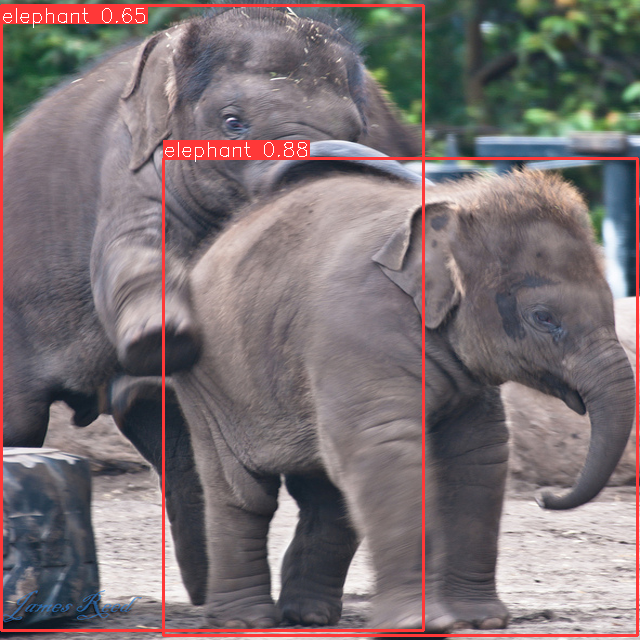

In [6]:
test_pred = yolo_model.model(elephant[0])  # yolo_model_copied
test_pred.print()
test_pred.show()

image 1/1: 640x640 2 elephants
Speed: 2.9ms pre-process, 15.0ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)


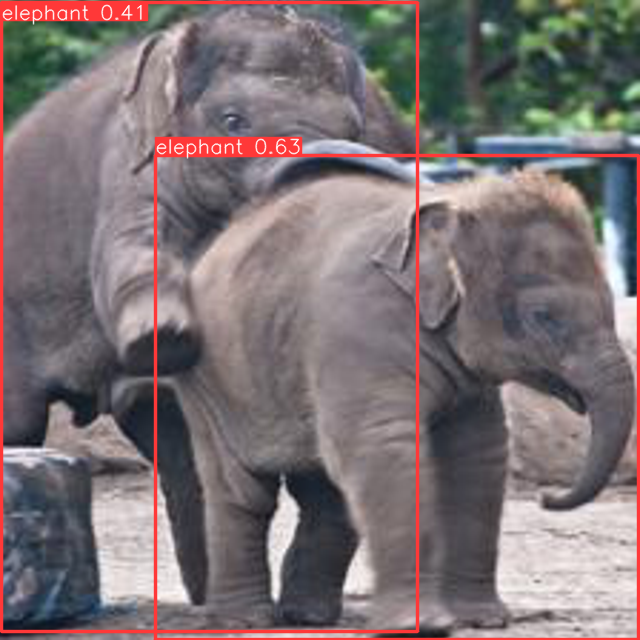

In [7]:
test_pred = yolo_model.model(elephant_adversarial[0])  # yolo_model_copied
test_pred.print()
test_pred.show()

In [8]:
target_lable = ['elephant'] 

# Purpose is selecting boxes elephant exists. 

"""
#################        COCO LABELS          #################
"""

COCO_INSTANCE_CATEGORY_NAMES = [
    "person", "bicycle", "car", "motorcycle", "airplane",
    "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird",
    "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed",
    "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock",
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush",
]

In [14]:
"""
#################        EXPERIMENTS UTILS        #################
"""
def extract_predictions(predictions_, conf_thres, iou_thres):
    # Get the predicted class
    predictions_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions_["labels"])]
    
    if len(predictions_class) < 1:
        return [], [], []

    # Get the predicted bounding boxes
    predictions_box = [i[:4] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])

    # Get a list of index with score greater than threshold
    threshold = conf_thres
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) == 0:
        return [], [], []

    # predictions in score order
    predictions_boxes = [predictions_box[i] for i in predictions_t]
    predictions_classes = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]

    nms_result = nms(boxes=torch.tensor(predictions_boxes), 
                     scores=torch.tensor(predictions_scores), 
                     iou_threshold=iou_thres,
                     )
    
    nms_classes = [predictions_classes[i] for i in nms_result]
    nms_boxes = [predictions_boxes[i] for i in nms_result]
    nms_scores = [predictions_scores[i] for i in nms_result]

    # print(nms_classes, nms_boxes, nms_scores)

    return nms_classes, nms_boxes, nms_scores


def plot_image_with_boxes(img, boxes, pred_cls, pred_score, title):
    # plt.style.use("ggplot")
    text_size = 1
    text_th = 3
    rect_th = 3

    for i in range(len(boxes)):
        cv2.rectangle(
            img,
            (int(boxes[i][0]), int(boxes[i][1])),
            (int(boxes[i][2]), int(boxes[i][3])),
            color=(204, 237, 0),
            thickness=rect_th,
        )
        # Write the prediction class
        cv2.putText(
            img,
            f"{pred_cls[i]}: {pred_score[i]*100:.1f}",
            (int(boxes[i][0]), int(boxes[i][1])+30),
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            color=(204, 237, 0),
            thickness=text_th,
        )

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

In [15]:
"""
#################        CONSTANT CONFIGURATION          #################
"""

patch_shape = (3, 120, 120)  # C H W
max_iter = 100
batch_size = 16
lr=5.0
conf_thres = 0.25
iou_thres = 0.45
is_targeted = False
"""
#####################  MAKE A DETECTOR For Adversarial Data ########################3
"""
detector = PyTorchYolo(model=yolo_model,
                       device_type="gpu",
                       input_shape=(3, 640, 640),
                       clip_values=(0, 255),
                       attack_losses=("loss_total",)
                      )

"""
#####################  MAKE A COPIED DETECTOR  FOR Origin Data ########################3
"""
detector_copied = PyTorchYolo(model=yolo_model_copied,
                              device_type="gpu",
                              input_shape=(3, 640, 640),
                              clip_values=(0, 255),
                              attack_losses=("loss_total", )
)

In [16]:
pred_clean = detector_copied.predict(x=elephant)

In [17]:
pred_adv = detector.predict(x=torch.tensor(elephant_adversarial))
# Torch.tensor() 함수를 사용하여 NumPy 배열을 PyTorch 텐서로 변환


Predictions image 0:


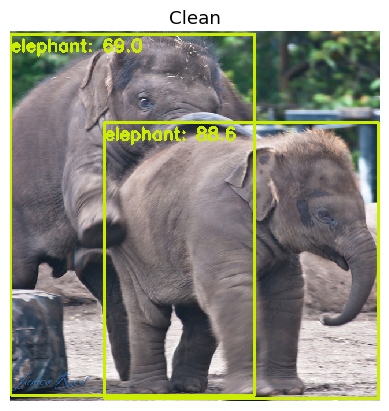


Predictions image 1:


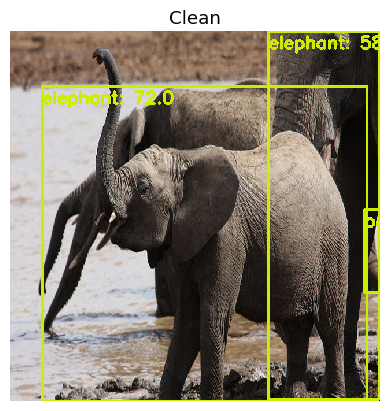


Predictions image 2:


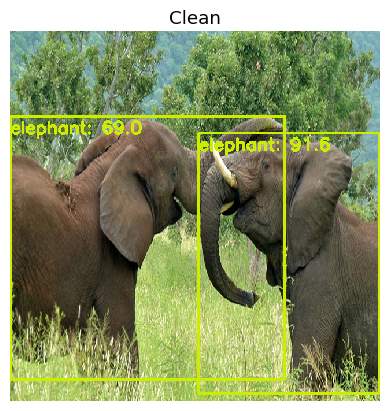


Predictions image 3:


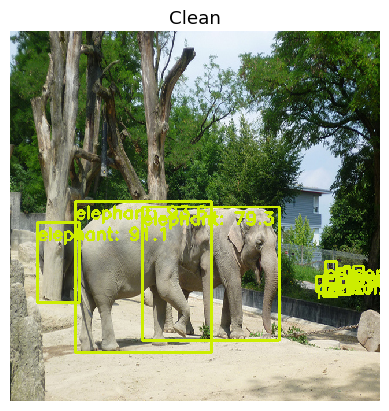


Predictions image 4:


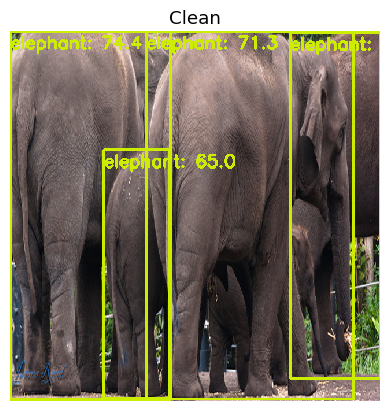


Predictions image 5:


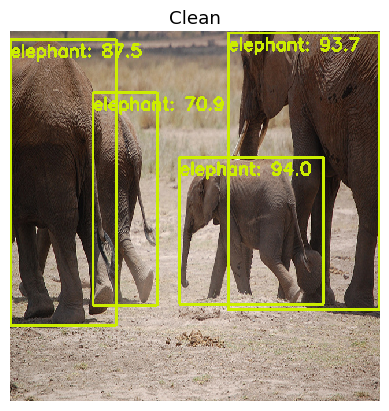


Predictions image 6:


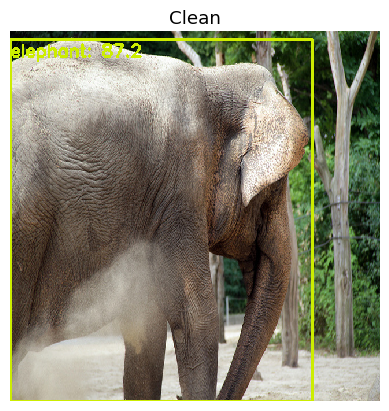


Predictions image 7:


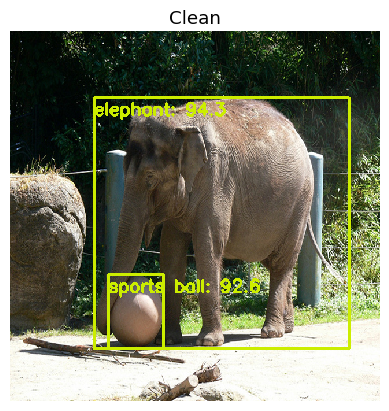


Predictions image 8:


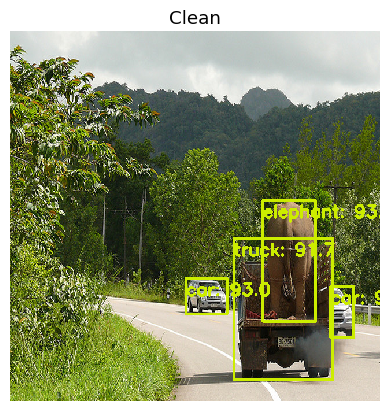


Predictions image 9:


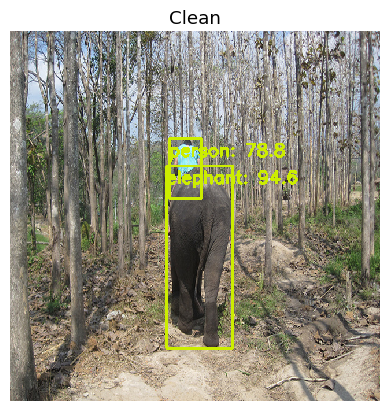


Predictions image 10:


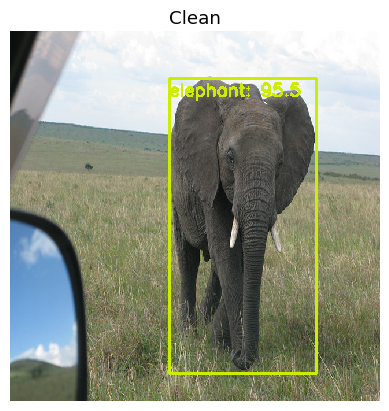

In [20]:
for i in range(elephant.shape[0]):
    if i > 10:
        break
    print(f"\nPredictions image {i}:")

    # Process predictions
    pred_classes, pred_boxes, pred_scores = extract_predictions(pred_clean[i], conf_thres=conf_thres, iou_thres=iou_thres)

    # Plot predictions
    plot_image_with_boxes(img=elephant[i].transpose(1, 2, 0).copy(),
                          boxes=pred_boxes,
                          pred_cls=pred_classes,
                          pred_score=pred_scores,
                          title='Clean')



Predictions image 0:


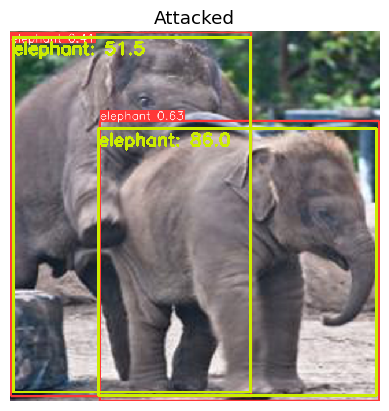


Predictions image 1:


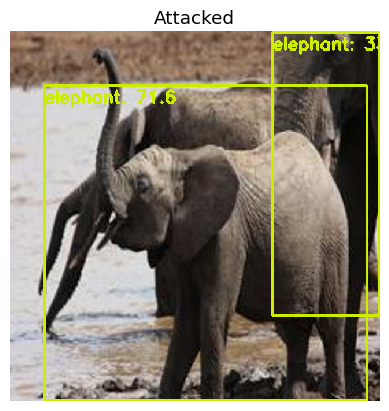


Predictions image 2:


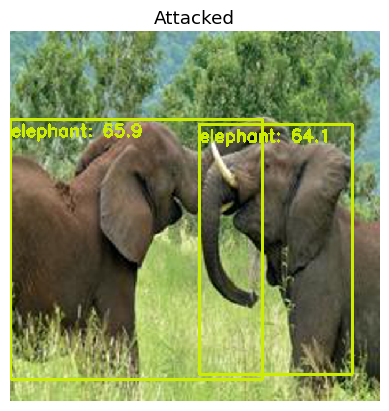


Predictions image 3:


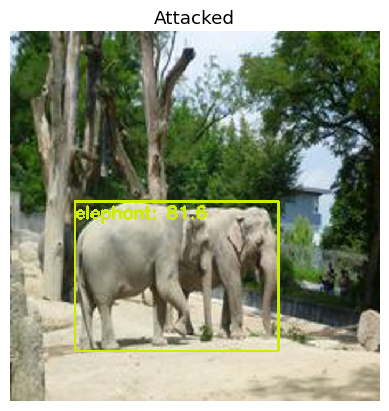


Predictions image 4:


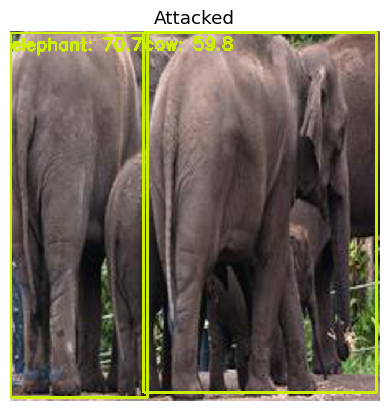


Predictions image 5:


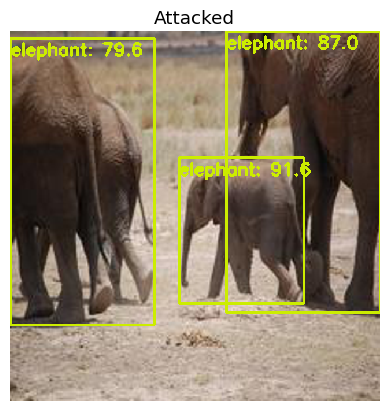


Predictions image 6:


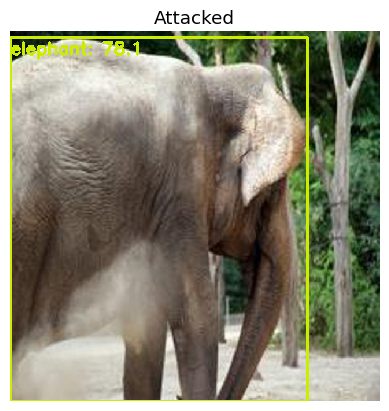


Predictions image 7:


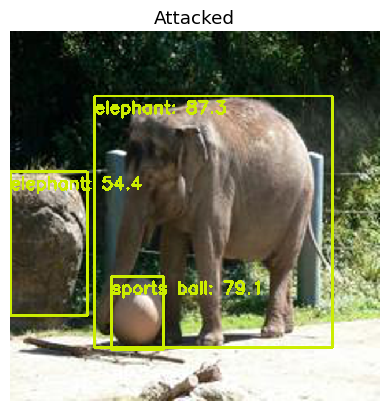


Predictions image 8:


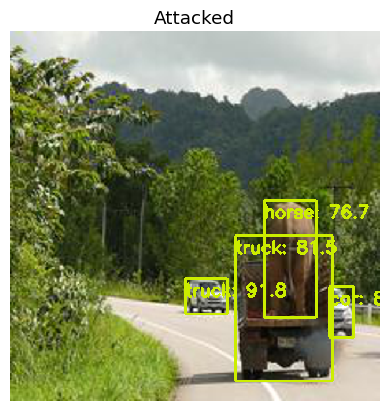


Predictions image 9:


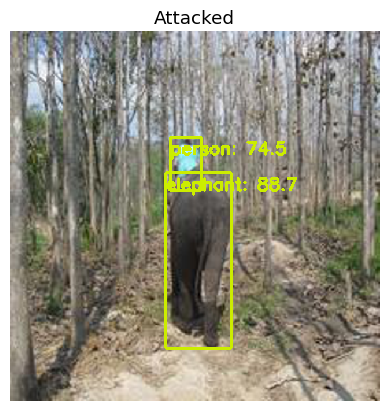


Predictions image 10:


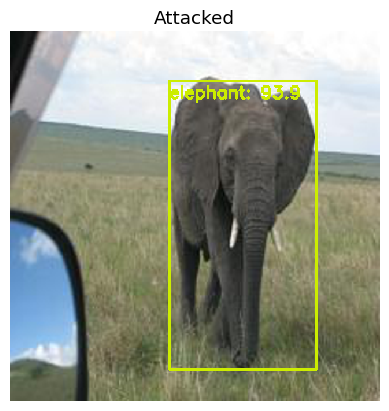

In [21]:
for i in range(torch.tensor(elephant_adversarial).shape[0]):
    if i > 10:
        break
    print(f"\nPredictions image {i}:")

    # Process predictions
    pred_classes2, pred_boxes2, pred_scores2 = extract_predictions(pred_adv[i], conf_thres=conf_thres, iou_thres=iou_thres)

    # Plot predictions
    plot_image_with_boxes(elephant_adversarial[i].transpose(1, 2, 0).copy(),
                          boxes=pred_boxes2,
                          pred_cls=pred_classes2,
                          pred_score=pred_scores2,
                          title='Attacked')

In [29]:
def calculate_average_count(predictions):
    count = 0
    for i in range(len(predictions)):
        pred = predictions[i]
        labels = pred['labels']
        count += np.count_nonzero(labels == 20)  # 20은 elephant 클래스의 인덱스입니다.
    average_count = count / len(predictions)
    return average_count

def calculate_average_probability(predictions):
    total_prob = 0
    for i in range(len(predictions)):
        pred = predictions[i]
        labels = pred['labels']
        scores = pred['scores']
        for j in range(len(labels)):
            if labels[j] == 20:  # 20은 elephant 클래스의 인덱스입니다.
                total_prob += scores[j].item()
    average_prob = total_prob / len(predictions)
    return average_prob

# 코끼리 사진에 대한 detection 결과 분석
avg_count_clean = calculate_average_count(pred_clean)
avg_prob_clean = calculate_average_probability(pred_clean)

# single pixel attack이 적용된 코끼리 사진에 대한 detection 결과 분석
avg_count_adv = calculate_average_count(pred_adv)
avg_prob_adv = calculate_average_probability(pred_adv)

print("Detection Results for Elephant Images:")
print("Average Elephant Count (Clean):", avg_count_clean)
print("Average Elephant Probability (Clean):", avg_prob_clean)
print()
print("Detection Results for Adversarial Elephant Images:")
print("Average Elephant Count (Adversarial):", avg_count_adv)
print("Average Elephant Probability (Adversarial):", avg_prob_adv)


Detection Results for Elephant Images:
Average Elephant Count (Clean): 1951.7527173913043
Average Elephant Probability (Clean): 21.683696189673498

Detection Results for Adversarial Elephant Images:
Average Elephant Count (Adversarial): 1380.1195652173913
Average Elephant Probability (Adversarial): 15.968417135749325
